## Plots used in the paper

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import numpy as np
from pygam import LinearGAM, f, s, te 
from tueplots import bundles

import warnings
warnings.filterwarnings("ignore")

### Figure 1 (Heatmap): Hourly bike traffic recorded by a single counter at Unterführung Steinlach in Tübingen

In [2]:
# Load raw bike data
bike_data = pd.read_csv("../data/full_bike_data_cleaned.csv", low_memory=False) 
bike_data['timestamp'] = pd.to_datetime(bike_data['timestamp'], utc = True, errors='coerce').dt.tz_convert('Europe/Berlin')

In [3]:
# Get data for specific counter site in specific city
city = "Stadt Tübingen" # Select city
counter_site = 'Unterführung Steinlach/Karlstraße Südseite - Steinlachallee' # Select counter site
site_data = bike_data[(bike_data['city'] == city) & (bike_data['counter_site'] == counter_site)]

In [4]:
# Helper functions to prepare data and create plot
def prepare_data(df):
    '''Extracts year, day of year, and hour from timestamp and ensures timezone is Europe/Berlin'''
    if df['timestamp'].dt.tz is None:
        df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize('UTC')
    df['timestamp'] = df['timestamp'].dt.tz_convert('Europe/Berlin')
    
    df['year'] = df['timestamp'].dt.year
    df['day_of_year'] = df['timestamp'].dt.dayofyear
    df['hour'] = df['timestamp'].dt.hour
    
    return df

def create_yearly_strip_plot(df):
    '''Creates a strip plot of bike counts by day of year and hour for each year in the data'''
    years = sorted(df['year'].unique())
    n_years = len(years)

    # Apply style sheet for ICML 2024
    plt.rcParams.update(bundles.icml2024(column="full", nrows=7, ncols=n_years))
    
    # Setup Figure
    fig, axes = plt.subplots(1, n_years, sharey=True)
    
    # Handle single year case where axes is not a list
    if n_years == 1:
        axes = [axes]

    # Global Color Settings
    vmin, vmax = 0, df['count'].quantile(0.99)
    
    # Y-Axis formatting (Months)
    month_starts = [0, 31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    for i, year in enumerate(years):
        ax = axes[i]
        
        # Prepare Data
        df_year = df[df['year'] == year]
        pivot = df_year.pivot_table(index='day_of_year', columns='hour', values='count', aggfunc='sum')
        pivot = pivot.reindex(index=range(1, 367), columns=range(0, 24), fill_value=0)
        pivot = pivot.fillna(0)
        
        # Plot Heatmap
        # We keep aspect='auto' because 366x24 data needs to stretch to fit the shape
        im = ax.imshow(pivot, cmap='Blues', aspect='auto', 
                       vmin=vmin, vmax=vmax, origin='upper',
                       extent=[0, 24, 366, 0])
        
        # Labeling
        ax.set_title(str(year), pad=5, fontsize=10)
        
        # X-Axis
        ax.set_xticks([0, 6, 12, 18])
        ax.set_xticklabels(['00', '06', '12', '18'], rotation=90, fontsize=8)
        ax.tick_params(axis='x', length=2)
        
        # Y-Axis (months)
        if i == 0:
            ax.set_yticks(month_starts)
            ax.set_yticklabels(month_names, fontsize=10)
        else:
            ax.tick_params(left=False) 
            
    # Add colorbar to the figure
    cbar_ax = fig.add_axes([1.01, 0.15, 0.02, 0.6]) 
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Bike Count', fontsize=10) 
    cbar.ax.tick_params(labelsize=10)
    
    # Master Title
    #fig.suptitle('Bike Traffic Unterführung Steinlach, Tübingen') 
    
    return fig

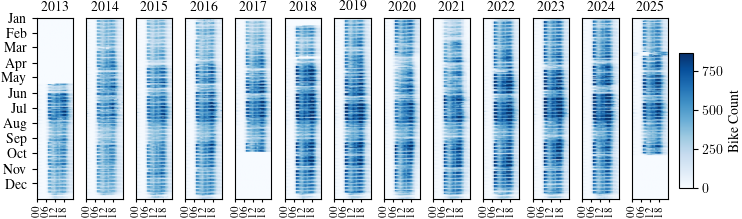

In [5]:
# Execute plot
df_agg = prepare_data(site_data)
fig = create_yearly_strip_plot(df_agg)
#fig.savefig("../figures/bike_traffic_tuebingen.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Figure 2 (line plot + histogram): Change in bike counts depending on temperature relative to the mean temperature

In [6]:
# Load weather and data and MSTL results
mstl_data = pd.read_csv("../data/mstl_results_clean.csv", low_memory=False)
weather_data = pd.read_csv("../data/weather_per_city.csv", low_memory=False)

#### Train GAMs for predictions

In [7]:
## Prepare residual data for GAMs

# Extract columns relevant for GAMS
residual_data = mstl_data[['timestamp',
 'city',
 'counter_site',
'seasonal_8766',
'residual']].copy()

# Remove rows with column names instead of values
residual_data = residual_data[residual_data['timestamp']!='timestamp']
residual_data['res_8766'] = residual_data["seasonal_8766"].astype(float) + residual_data["residual"].astype(float)
residual_data['id'] = residual_data.groupby(['city', 'counter_site']).ngroup()


# Merge with weather data by city and date (in weather data) and timestamp (in residual data)
merged_data = pd.merge(residual_data, weather_data, left_on=['city', residual_data['timestamp']], right_on=['city', weather_data['date']], how='left')

# Reference timestamp (UTC)
ref = pd.Timestamp(min(residual_data['timestamp'].tolist()))

# Convert timestamp to numeric hours since reference time
t_0 = pd.to_datetime(merged_data['timestamp'], utc=True, errors='coerce')

# Calculate difference in hours (vectorized)
merged_data['timestamp_number'] = (t_0 - ref).dt.total_seconds() / 3600.0

def logdiff_to_percent(delta):
    '''Converts log-differences to percentage changes.'''
    return (np.exp(delta) - 1.0) * 100

def defineX_y(city_data, forecast=False, full=False):
    '''Defines feature matrix X and target vector y for a given city's data.'''
    y = city_data['res_8766'].astype(float).values

    if forecast:
        X = city_data[['timestamp_number', 'id',
                       'forecast_temperature_2m', 'forecast_rain', 'forecast_snowfall']].astype(float).copy()
        X.columns = ['timestamp_number', 'id', 'temperature_2m', 'rain', 'snowfall']

        # Keep only rows where forecast values exist and y exists
        mask = ~X[['temperature_2m', 'rain', 'snowfall']].isna().any(axis=1) & ~np.isnan(y)
        X = X[mask]
        y = y[mask]

    else:  # Use actual data
        X = city_data[['timestamp_number', 'id', 'temperature_2m', 'rain', 'snowfall']].astype(float).copy()

        if full:
            # Keep all rows where actual values exist
            mask = ~X.isna().any(axis=1) & ~np.isnan(y)
            X = X[mask]
            y = y[mask]
        else:
            # Keep only rows where forecast exists (to align lengths)
            X_forecast = city_data[['forecast_temperature_2m', 'forecast_rain', 'forecast_snowfall']].astype(float)
            mask = ~X_forecast.isna().any(axis=1) & ~X.isna().any(axis=1) & ~np.isnan(y)
            X = X[mask]
            y = y[mask]

    return X.values, y

def trainGAM(X,y):
    """Trains a LinearGAM model on the provided features X and target y."""
    gam = LinearGAM(
    s(0, n_splines=10, lam=1) +          # timestamp_number (drift)
    f(1, lam=50) +                       # id
    s(2, n_splines=6) +                  # temp
    s(3, n_splines=5, lam=2) +           # rain
    s(4, n_splines=5, lam=2) +           # snow
    te(2, 3, n_splines=4, lam=2)         # temp × rain
    ).fit(X, y)
    return gam

In [8]:
# Train GAMs for each city for actual and predicted weather
city_models = {"actual": {}, "predicted": {}}

for city in merged_data["city"].unique():
    city_data = merged_data[merged_data["city"] == city]
    X_act, y_act = defineX_y(city_data, forecast=False, full=False)
    gam_act = trainGAM(X_act, y_act)
    city_models["actual"][city] = {
        "gam": gam_act,
        "X": X_act,
        "y": y_act
    }

    X_pred, y_pred = defineX_y(city_data, forecast=True, full=False)
    gam_pred = trainGAM(X_pred, y_pred)
    city_models["predicted"][city] = {
        "gam": gam_pred,
        "X": X_pred,
        "y": y_pred
    }


#### Plot predicted values

In [9]:
# Helper function to plot temperature effect with predicted histogram
def plot_temp_effect_with_predicted_hist(
    city_models,
    temp_col=2,
    rain_col=3,
    snow_col=4,
    temp_min=-10,
    temp_max=35,
    rain_levels=(0, 1.0, 3.0),
    n_bins=30
):
    # --- Compute curves with CIs ---
    def compute_curves(source):
        all_X = np.vstack([v["X"] for v in city_models[source].values()])
        global_mean_temp = all_X[:, temp_col].mean()
        temps = np.linspace(temp_min, temp_max, 30)
        snow_fixed = 0.0
        curves = {r: [] for r in rain_levels}

        for city, data in city_models[source].items():
            gam = data["gam"]
            X_city = data["X"]
            X_base = X_city.mean(axis=0)
            X_base[temp_col] = global_mean_temp
            X_base[rain_col] = 0.0
            X_base[snow_col] = snow_fixed
            X_base_mat = gam._modelmat(np.tile(X_base, (len(temps), 1)))

            for r in rain_levels:
                X_ref = np.tile(X_base, (len(temps), 1))
                X_ref[:, temp_col] = temps
                X_ref[:, rain_col] = r
                X_ref_mat = gam._modelmat(X_ref)
                delta_eta = (X_ref_mat - X_base_mat) @ gam.coef_
                curves[r].append((np.exp(delta_eta) - 1) * 100)

        # Aggregate across cities
        out = {}
        for r in rain_levels:
            arr = np.vstack(curves[r])
            out[r] = {
                "mean": arr.mean(axis=0),
                "low":  np.percentile(arr, 2.5, axis=0),
                "high": np.percentile(arr, 97.5, axis=0),
            }
        return temps, out, global_mean_temp

    # Compute curves
    temps, curves_actual, mean_temp = compute_curves("actual")
    _, curves_pred, _ = compute_curves("predicted")

    # --- Temperature histogram ---
    all_actual = np.vstack([v["X"] for v in city_models["actual"].values()])[:, temp_col]
    all_pred   = np.vstack([v["X"] for v in city_models["predicted"].values()])[:, temp_col]

    bins = np.linspace(temp_min, temp_max, n_bins)
    counts_actual, _ = np.histogram(all_actual, bins=bins)
    counts_pred, _   = np.histogram(all_pred, bins=bins)

    frac_actual = counts_actual / counts_actual.sum()
    frac_pred   = counts_pred / counts_pred.sum()

    # --- Plot ---
    plt.rcParams.update(bundles.icml2024(column="half", nrows=1, ncols=1))
    
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    # Force histograms into background
    ax2.set_zorder(0)
    ax1.set_zorder(1)
    ax1.patch.set_alpha(0)   # transparent so bars show through

    width = bins[1] - bins[0]
    ax2.patch.set_alpha(0)

    # Histogram bars
    h_actual = ax2.bar(
        bins[:-1], frac_actual,
        width=width, color="#808080", alpha=0.5,
        align="edge", zorder=0.5
    )
    h_pred = ax2.bar(
        bins[:-1], frac_pred,
        width=width, color="#E0E0E0", alpha=0.5,
        align="edge", zorder=0.5
    )

    ax2.set_ylabel("Fraction of data", fontsize=28, labelpad=10)
    ax2.set_ylim(0, max(frac_actual.max(), frac_pred.max()) * 1.1)

    actual_colors = ["#084184", "#B23A8A", "#007A5A"]
    pred_colors   = ["#418ac1", "#D46BAF", "#3FAF8A"]

    # Curves with CI
    for r, c_actual, c_pred in zip(rain_levels, actual_colors, pred_colors):
        # Actual
        ax1.fill_between(
            temps,
            curves_actual[r]["low"],
            curves_actual[r]["high"],
            color=to_rgba(c_actual, 0.20),
            zorder=2
        )
        ax1.plot(
            temps,
            curves_actual[r]["mean"],
            lw=3,
            color=c_actual,
            label=f"Rain={r} mm (obs.)",
            zorder=3
        )

        # Predicted
        ax1.fill_between(
            temps,
            curves_pred[r]["low"],
            curves_pred[r]["high"],
            color=to_rgba(c_pred, 0.20),
            zorder=2.5
        )
        ax1.plot(
            temps,
            curves_pred[r]["mean"],
            lw=3,
            color=c_pred,
            label=f"Rain={r} mm (pred.)",
            zorder=4
        )

    # Global mean temp line
    ax1.axvline(
        mean_temp,
        color="black",
        lw=2,
        ls="--",
        label=rf"Global mean temp $\approx$ {mean_temp:.1f}$^\circ$C",
        zorder=4
    )
    # Add text next to the line
    ax1.text(
        mean_temp + 0.5,  # slightly to the right of the line
        ax1.get_ylim()[1]*(-1.1),  # near top of y-axis
        rf"mean temp. $\approx$ {mean_temp:.1f}$^\circ$C",
        color="black",
        fontsize=22,
        ha="left",  # horizontal alignment
        va="top",   # vertical alignment
        rotation=0
    )
    # Labels, ticks, and axis limits
    ax1.set_xlabel("Temperature (°C)", fontsize=28)
    ax1.set_ylabel(r"Change in bike counts (\%)", fontsize=28, labelpad=10)
    ax1.set_yticks([-75, -50, -25, 0, 25, 50, 75])
    
    ax1.tick_params(axis='both', which='major', labelsize=24)
    ax2.tick_params(axis='y', which='major', labelsize=24)

    # Add margins at ends
    ax1.margins(x=0.02, y=0.05)

    # X-axis limits
    ax1.set_xlim(temp_min, temp_max)

    # Combine legends (removed for clarity)
    #handles1, labels1 = ax1.get_legend_handles_labels()
    #handles2 = [h_actual, h_pred]
    #labels2 = ["Observed temperature", "Predicted temperature"]
    #ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper left", fontsize=14)

    #fig.savefig("../figures/pred_vs_obs_wheather.pdf", format="pdf", bbox_inches="tight")
    plt.show()

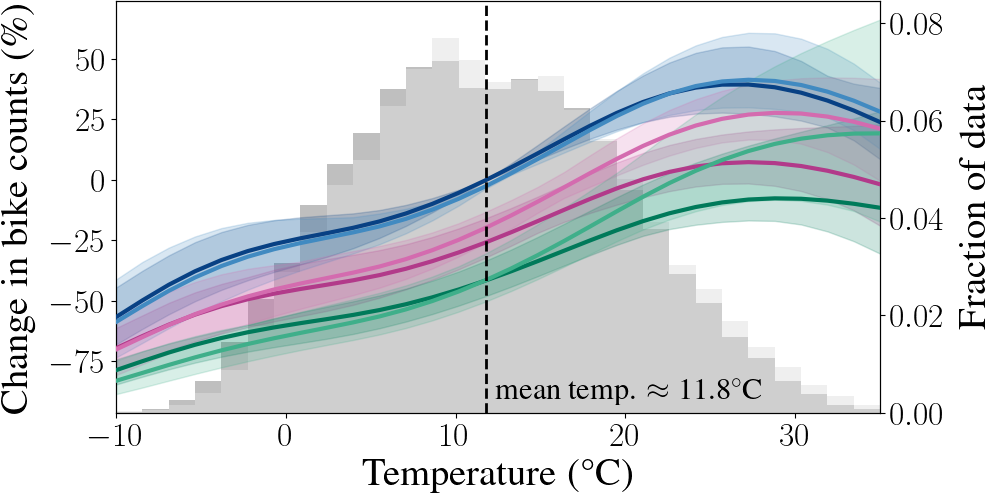

In [10]:
# Execute plot
plot_temp_effect_with_predicted_hist(
    city_models,
    temp_col=2,
    rain_col=3,
    snow_col=4,
)